In [1]:
import pydicom
import os,re
import numpy as np
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from pydicom.dataset import Dataset, FileDataset
import tempfile
import SimpleITK as sitk
import math
from ipywidgets import interact, fixed
from skimage.transform import resize
from IPython.display import clear_output
from scipy.ndimage import zoom
import scipy.misc
from sys import platform
import shutil

from MyProcessDicom import *
from RegistrationMethod import *
from ServerDicomIO import *
from icafeAPI import generate_centerline
platform

'win32'

In [33]:
import importlib
import sys
sys.path.append(r'..\FRAPPE')
import DB
importlib.reload(DB)
from DB import DB

# process list
# first in TP as reference
caselist = [
    {'pid': '9404954','TP':[0,1,2,3,4,5,6,8,10],'side':'R'}
]

# getdcmpath('9911265',0,'L'),getdcmpath('9911265',1,'R'),getdcmpath('9911265',8,'R')

In [39]:
# #split seqs for a case
getFileFromDB(caselist)

********  tp 0 ************
ahaknee0tp29  exist
dcm path for TPid 0 Z:/OAI Baseline/gc0/9404954/10728113
copying Z:/OAI Baseline/gc0/9404954/10728113/076.dcm  Z:/OAI Baseline/gc0/9404954/10728113/038.dcm  
********  tp 1 ************
ahaknee12tp29  exist
dcm path for TPid 1 Z:/OAI 12 Months/1.C.2/9404954/20060223/10862212
copying Z:/OAI 12 Months/1.C.2/9404954/20060223/10862212/076.dcm 
********  tp 2 ************
ahaknee18tp29  exist
cannot find dcm path for TPid 2
********  tp 3 ************
ahaknee24tp29  exist
dcm path for TPid 3 Z:/OAI 24 Months/3.C.2/9404954/20070518/11732414
copying Z:/OAI 24 Months/3.C.2/9404954/20070518/11732414/076.dcm  Z:/OAI 24 Months/3.C.2/9404954/20070518/11732414/014.dcm 
********  tp 4 ************
ahaknee30tp29  exist
dcm path for TPid 4 Z:/OAI 30 Months/results/4.G.1/9404954/20070817/11925205
copying Z:/OAI 30 Months/results/4.G.1/9404954/20070817/11925205/076.dcm  Z:/OAI 30 Months/results/4.G.1/9404954/20070817/11925205/012.dcm  Z:/OAI 30 Months/resu

In [36]:
def do_registration(casei, regis_fun):
    pi = casei['pid']
    side = casei['side']
    precasepath = split_seq_path + pi + side + '/'
    regtp = casei['TP']
    if len(regtp) < 2:
        print(pi, 'not enough TPs')
        return
    tp1 = regtp[0]
    print("Fixed Image %d" % tp1)
    tp1_casepath = precasepath + 'TP0/'
    fixed_image = get_dicom_series(tp1_casepath)
    
    icafesavepath = icafepath+'0_P'+pi+side+'_U'+'/'
    if not os.path.exists(icafesavepath):
        print('Init icafe dir')
        os.mkdir(icafesavepath)
    
    # isotropic resolution
    img1 = resample_image(fixed_image)
    sitk.WriteImage(sitk.Cast(img1, sitk.sitkInt16), icafesavepath + 'TH_0_P' + pi + side + '_U.tif')
    print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_U.tif')
    sitk.WriteImage(sitk.Cast(img1, sitk.sitkInt16), icafesavepath + 'TH_0_P'+  pi + side + '_US100.tif')
    print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_US100.tif')
    
    fixed_image = preprocess(fixed_image)
    fixed_ret, resampled_ret = [], []
    for tp2 in regtp[1:]:
        #if tp2 != 1: continue
        print("************************************************")
        print("Processing %d......" % tp2)
        tp2_casepath = getdcmpath(pi,tp2,side)
        if tp2_casepath is None:
            print('cannot find dcm path for TPid', tp2)
            continue
        
        tp2_casepath = precasepath + 'TP' + str(tp2) + '/'
        print("reading image......", pi + 'TP' + str(tp2))
        moving_image = get_dicom_series(tp2_casepath)
        moving_image = preprocess(moving_image)
        show_images(fixed_image, moving_image)
        
        transform = regis_fun(fixed_image, moving_image)
        if tp2==10:
            SEQ = 'S109'
        else:
            SEQ = 'S10'+str(tp2)
        sitk.WriteTransform(transform, transform_path + 'affine_P'+  pi + side + 'U' + SEQ + '.tfm')
        tmp_img = transform_img(fixed_image, moving_image, transform)

#         sitk.WriteImage(sitk.Cast(exqimg, sitk.sitkInt16), icafesavepath + 'TH_0_P'+  pi + side + '_U' + SEQ + '.tif')
#         print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_U' + SEQ + '.tif')
        fixed_ret.append(fixed_image)
        resampled_ret.append(tmp_img)
    return fixed_ret, resampled_ret

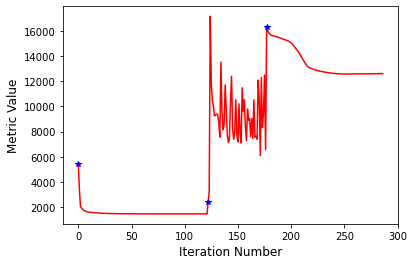

Final metric value: 12600.873015509113
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 110.


In [40]:
for casei in caselist:
    ret = do_registration(casei, affine_registration)
    fixed_ret, resampled_ret = ret
#     if ret is not None:
#         fixed_image, moving_resampled = ret
#         interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), 
#                  fixed = fixed(fixed_image), moving=fixed(moving_resampled));

In [41]:
show_mixed_images(fixed_ret[0], resampled_ret[0])

interactive(children=(IntSlider(value=37, description='image_z', max=74), FloatSlider(value=0.5, description='…

In [42]:
for case in caselist:
    pid = case['pid']
    side = case['side']
    for j in range(len(case['TP'])):
        generate_centerline(pid, case['TP'][j], side)
    file_path = r'../centerline/P'+pid+side+'/tracing_raw_ves_TH_'+str(case['TP'][0])+'_P'+pid+side+'_U.swc'
    icafesavepath = icafepath+'0_P'+pi+side+'_U'+'/'
    shutil.copy(file_path, icafesavepath)

ahaknee0tp29  exist
ahaknee12tp29  exist
ahaknee18tp29  exist
ahaknee24tp29  exist
ahaknee30tp29  exist
ahaknee36tp29  exist
ahaknee48tp29  exist
ahaknee72tp29  exist
ahaknee96tp29  exist


In [9]:
# case = caselist[0]
# df1, line1 = get_centerline(case['pid'], case['TP'][0], case['side'])
# df1.head(20)
# df2, line2 = get_centerline(case['pid'], case['TP'][1], case['side'])
# df2.head(20)

In [46]:
def get_centerline(pid, TPid, side='L'):
    dir_path = r'../centerline/P'+pid+side
    file_path = dir_path+'/tracing_raw_ves_TH_'+str(TPid)+'_P'+pid+side+'_U.swc'
    df = pd.read_csv(file_path, header=None, sep=' ',index_col=0, names=['vessel_id','x','y','z','undefined','last_id'])
    line = np.array([df['x'], df['y'], df['z']]).T
    return df, line

def generate_regis_with_centerline(line1, line2, transform):
    points = []
    for i in range(line1.shape[0]):
        tmp_point = transform.TransformPoint((line1[i][0], line1[i][1], i))
        points.append(tmp_point)
    ans = np.array(points)
    ans[:,2] = np.round(ans[:,2])
    dx, dy = [], []
    for i in range(ans.shape[0]):
        if int(ans[i][2]) >= line2.shape[0]:
            break
        dx.append(ans[i][0] - line2[int(ans[i][2])][0])
        dy.append(ans[i][1] - line2[int(ans[i][2])][1])
    dx = np.array(dx)
    dy = np.array(dy)
    displacement_image = sitk.Image([384,384,dx.shape[0]], sitk.sitkVectorFloat64)
    # The only point that has any displacement is (0,0)
    for i in range(dx.shape[0]):
        displacement = (-dx[i],-dy[i],0)
        for j in range(384):
            for k in range(384):
                displacement_image[j,k,i] = displacement
    return sitk.DisplacementFieldTransform(displacement_image)

In [47]:
def registration_with_centerline(case):
    pid = case['pid']
    side = case['side']
    regtp = case['TP']
    if len(regtp) < 2:
        print(pi, 'not enough TPs')
        return
    tp1 = regtp[0]
    print("Fixed Image %d" % tp1)
    _, line1 = get_centerline(pid, tp1, side)
    for tp2 in regtp[1:]:
        tp2_casepath = getdcmpath(pi,tp2,side)
        if tp2_casepath is None:
            print('cannot find dcm path for TPid', tp2)
            continue
        _, line2 = get_centerline(pid, tp2, side)
        if tp2==10:
            SEQ = 'S109'
        else:
            SEQ = 'S10'+str(tp2)
        affine = sitk.ReadTransform(transform_path + 'affine_P'+  case['pid'] + case['side'] + 'U' + SEQ + '.tfm')
        print("Please wait...(TP"+str(tp2)+" is being processed)")
        displacement_field_transform = generate_regis_with_centerline(line1, line2, affine)
        sitk.WriteTransform(displacement_field_transform, transform_path + 'displacement_P'+  pi + side + 'U' + SEQ + '.tfm')
    return

In [48]:
for case in caselist:
    registration_with_centerline(case)

Fixed Image 0
ahaknee30tp29  exist
Please wait...(TP4 is being processed)
ahaknee36tp29  exist
Please wait...(TP5 is being processed)
ahaknee48tp29  exist
Please wait...(TP6 is being processed)
ahaknee72tp29  exist
Please wait...(TP8 is being processed)
ahaknee96tp29  exist
Please wait...(TP10 is being processed)


In [49]:
def generate_result(case):
    pid = case['pid']
    side = case['side']
    regtp = case['TP']
    icafesavepath = icafepath+'0_P'+pi+side+'_U'+'/'
    precasepath = split_seq_path + pi + side + '/'
    if len(regtp) < 2:
        print(pi, 'not enough TPs')
        return
    tp1 = regtp[0]
    tp1_casepath = precasepath + 'TP0/'
    fixed_image = get_dicom_series(tp1_casepath)
    fixed_image = empty_preprocess(fixed_image)
    print("Fixed Image %d" % tp1)
    for tp2 in regtp[1:]:
        tp2_casepath = getdcmpath(pi,tp2,side)
        if tp2_casepath is None:
            print('cannot find dcm path for TPid', tp2)
            continue
        tp2_casepath = precasepath + 'TP' + str(tp2) + '/'
        moving_image = get_dicom_series(tp2_casepath)
        space2 = moving_image.GetSpacing()
        if tp2==10:
            SEQ = 'S109'
        else:
            SEQ = 'S10'+str(tp2)
        moving_image = empty_preprocess(moving_image)
        print("Please wait...(TP"+str(tp2)+" is being processed)")
        affine = sitk.ReadTransform(transform_path + 'affine_P'+  case['pid'] + case['side'] + 'U' + SEQ + '.tfm')
        displacement_field_transform = sitk.ReadTransform(transform_path + 'displacement_P'+  pi + side + 'U' + SEQ + '.tfm')
        resampled = transform_img(fixed_image, moving_image, affine)
        resampled2 = transform_img(fixed_image, resampled, displacement_field_transform)
        resampled2 = resample_image(resampled2, space2)
        sitk.WriteImage(sitk.Cast(resampled2, sitk.sitkInt16), icafesavepath + 'TH_0_P' + pi + side + '_U' + SEQ + '.tif')
    return

In [50]:
for case in caselist:
    generate_result(case)

Fixed Image 0
ahaknee12tp29  exist
Please wait...(TP1 is being processed)
[384 384  75] [384, 384, 309]
ahaknee18tp29  exist
cannot find dcm path for TPid 2
ahaknee24tp29  exist
Please wait...(TP3 is being processed)
[384 384  75] [384, 384, 309]
ahaknee30tp29  exist
Please wait...(TP4 is being processed)
[384 384  75] [384, 384, 309]
ahaknee36tp29  exist
Please wait...(TP5 is being processed)
[384 384  75] [384, 384, 309]
ahaknee48tp29  exist
Please wait...(TP6 is being processed)
[384 384  75] [384, 384, 309]
ahaknee72tp29  exist
Please wait...(TP8 is being processed)
[384 384  75] [384, 384, 309]
ahaknee96tp29  exist
Please wait...(TP10 is being processed)
[384 384  75] [384, 384, 309]


In [17]:
# small demo
case = caselist[0]
pi = case['pid']
side = case['side']
precasepath = split_seq_path + pi + side + '/'
regtp = case['TP']
tp1, tp2 = regtp[0], regtp[1]
tp1_casepath = precasepath + 'TP0/'
fixed_image = get_dicom_series(tp1_casepath)

icafesavepath = icafepath+'0_P'+pi+side+'_U'+'/'
tp2_casepath = precasepath + 'TP' + str(tp2) + '/'

moving_image = get_dicom_series(tp2_casepath)
space2 = moving_image.GetSpacing()

fixed_image = empty_preprocess(fixed_image)
moving_image = empty_preprocess(moving_image)

In [10]:
affine = sitk.ReadTransform(transform_path + 'affine_P'+  case['pid'] + case['side'] + 'US101'+ '.tfm')
displacement_field_transform = sitk.ReadTransform(transform_path + 'displacement_P'+  pi + side + 'US101' + '.tfm')

In [11]:
resampled = transform_img(fixed_image, moving_image, affine)
show_mixed_images(fixed_image, resampled)

interactive(children=(IntSlider(value=37, description='image_z', max=74), FloatSlider(value=0.5, description='…

In [12]:
resampled2 = transform_img(fixed_image, resampled, displacement_field_transform)
show_mixed_images(fixed_image, resampled2)

interactive(children=(IntSlider(value=37, description='image_z', max=74), FloatSlider(value=0.5, description='…

In [19]:
resampled2 = resample_image(resampled2, space2)

[384 384  75] [384, 384, 309]


In [20]:
sitk.WriteImage(sitk.Cast(resampled2, sitk.sitkInt16), icafesavepath + 'TH_0_P' + pi + side + '_US101.tif')

In [28]:
# def our_pipeline(casei):
#     pi = casei['pid']
#     side = casei['side']
#     precasepath = split_seq_path + pi + side + '/'
#     regtp = casei['TP']
#     if len(regtp) < 2:
#         print(pi, 'not enough TPs')
#         return
#     tp1 = regtp[0]
#     print("Fixed Image %d" % tp1)
#     tp1_casepath = precasepath + 'TP0/'
#     fixed_image = get_dicom_series(tp1_casepath)
    
#     icafesavepath = icafepath+'0_P'+pi+side+'_U'+'/'
#     if not os.path.exists(icafesavepath):
#         print('Init icafe dir')
#         os.mkdir(icafesavepath)
    
#     # isotropic resolution
    
#     fixed_image = resample_image(fixed_image)
#     img1 = fixed_image
#     sitk.WriteImage(sitk.Cast(fixed_image, sitk.sitkInt16), icafesavepath + 'TH_0_P' + pi + side + '_U.tif')
#     print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_U.tif')
#     sitk.WriteImage(sitk.Cast(fixed_image, sitk.sitkInt16), icafesavepath + 'TH_0_P'+  pi + side + '_US100.tif')
#     print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_US100.tif')
    
# #     fixed_image = img1
#     fixed_image = preprocess(img1)
#     fixed_ret, resampled_ret = [], []
#     for tp2 in regtp[1:3]:
#         #if tp2 != 1: continue
#         print("************************************************")
#         print("Processing %d..." % tp2)
#         tp2_casepath = getdcmpath(pi,tp2,side) 
#         if tp2_casepath is None:
#             print('cannot find dcm path for TPid', tp2)
#             continue
        
#         tp2_casepath = precasepath + 'TP' + str(tp2) + '/'
#         print("reading image......", pi + 'TP' + str(tp2))
#         moving_image = get_dicom_series(tp2_casepath)
#         img2 = resample_image(moving_image)
#         moving_image = preprocess(img2)
        
#         if tp2 <=8:
#             transform = rigid_registration(fixed_image, moving_image, vis=False)
#             img2 = sitk.Resample(empty_preprocess(img2), empty_preprocess(img1), transform, sitk.sitkBSpline, 0.0, empty_preprocess(img2).GetPixelID())
#             moving_image = sitk.Resample(moving_image, fixed_image, transform, sitk.sitkBSpline, 0.0, moving_image.GetPixelID())
        
#         ffd_transform = bspline_intra_modal_registration(fixed_image, moving_image, vis=False)
#         exqimg = sitk.Resample(empty_preprocess(img2), empty_preprocess(img1), ffd_transform, sitk.sitkBSpline, 0.0, empty_preprocess(img2).GetPixelID())
#         tmp_img = exqimg
        
#         if tp2==10:
#             SEQ = 'S109'
#         else:
#             SEQ = 'S10'+str(tp2)
# #         exqimg = resample_image(exqimg)
#         sitk.WriteImage(sitk.Cast(exqimg, sitk.sitkInt16), icafesavepath + 'TH_0_P'+  pi + side + '_U' + SEQ + '.tif')
#         print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_U' + SEQ + '.tif')
#         fixed_ret.append(empty_preprocess(img1))
#         resampled_ret.append(empty_preprocess(tmp_img))
#     return fixed_ret, resampled_ret

In [28]:
# for casei in caselist:
#     our_pipeline(casei)